In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 14.46 MiB/s, done.


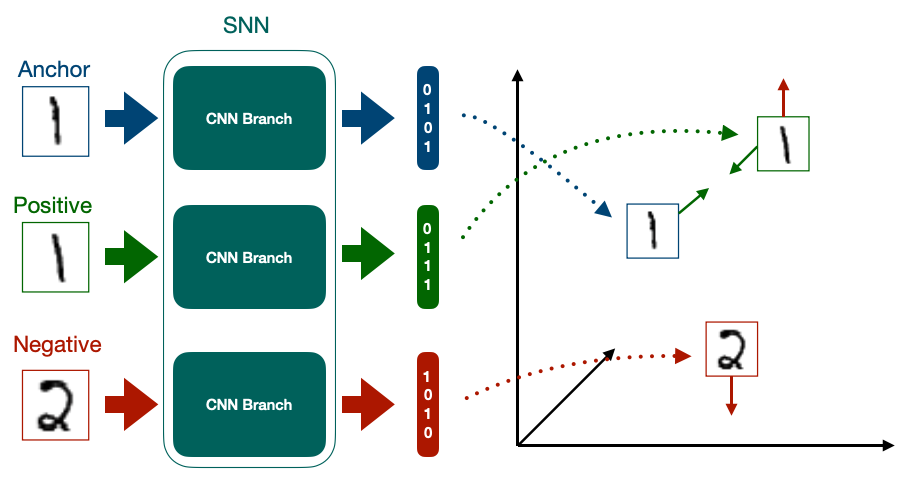

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR= '/content/Person-Re-Id-Dataset/train/'
CSV_FILE= '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE=32
LR = 0.001
EPOCHS = 15

DEVICE= 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[11]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

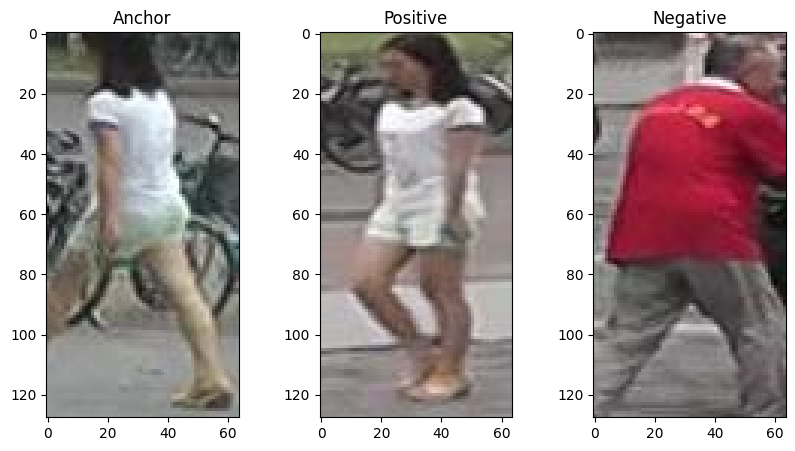

In [ ]:
from ast import NamedExpr
f, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df =train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

    def __init__(self,df):
      self.df=df

    def __len__(self):
      return len(self.df)

    def __getitem__(self,idx):

      row = self.df.iloc[idx]

      A_img = io.imread(DATA_DIR + row.Anchor)
      P_img = io.imread(DATA_DIR + row.Positive)
      N_img = io.imread(DATA_DIR + row.Negative)

      A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

      return A_img, P_img, N_img

In [ ]:
trainset= APN_Dataset(train_df)
validset= APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


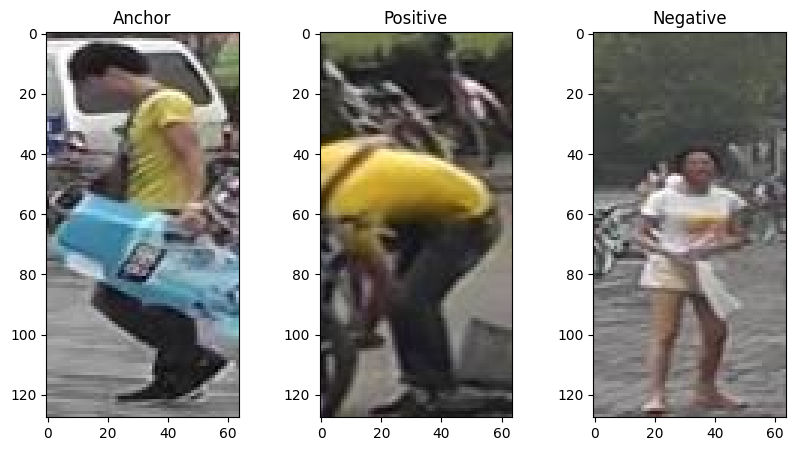

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

      def __init__(self, emb_size=512):
        super(APN_Model,self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained =True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

      def forward(self, images):
        embeddings = self.efficientnet(images)

        return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

      model.train()
      total_loss = 0.0

      for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs= model(P)
        N_embs= model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      return total_loss/ len(dataloader)



In [ ]:
def eval_fn(model, dataloader,  criterion):

      model.eval()
      total_loss = 0.0
      with torch.no_grad():
        for A, P, N in tqdm(dataloader):

          A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

          A_embs = model(A)
          P_embs= model(P)
          N_embs= model(N)

          loss = criterion(A_embs, P_embs, N_embs)


          total_loss += loss.item()

        return total_loss/ len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.inf
for i in range(EPOCHS):

   train_loss = train_fn(model, trainloader, optimizer, criterion)
   valid_loss = eval_fn(model, validloader, criterion)

   if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

   print(f"EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)")


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]

EPOCHS : (i+1) train_loss: (train_loss) valid_loss: (valid_loss)


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
      for i in tqdm(anc_img_names_arr):
        A = io.imread(DATA_DIR + i)
        A = torch.from_numpy(A).permute(2, 0, 1)/255.0
        A = A.to(DEVICE)
        A_enc = model(A.unsqueeze(0))
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

      encodings = np.array(encodings)
      encodings = pd.DataFrame(encodings)
      df_enc = pd.concat([anc_img_names, encodings], axis =1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:48<00:00, 82.84it/s]


In [ ]:
df_enc.to_csv('database.csv', index= False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.26335,-0.057957,-0.242597,0.455106,-1.179412,-1.299768,1.353272,-0.214951,-0.300190,...,0.425472,-0.247337,-0.368014,-0.817076,1.023394,-1.489716,0.017053,-1.380072,-0.375116,0.684744
1,1420_c3s3_061978_03.jpg,0.02704,-0.220949,-0.355977,0.030419,-1.539721,-0.948564,1.317710,-0.000559,-0.455428,...,0.112450,-0.089191,-0.897756,-0.907554,0.874977,-1.622429,-0.130213,-1.426382,-0.570175,0.555418
2,1420_c5s3_062565_05.jpg,0.12594,-0.200570,-0.274647,0.114320,-1.424606,-0.854430,1.397886,-0.051193,-0.398322,...,0.517092,-0.060886,-0.775751,-0.843077,0.838551,-1.501126,-0.213340,-1.456635,-0.523881,0.455129
3,1420_c6s3_085592_04.jpg,0.23303,0.006039,-0.466803,0.256012,-1.408386,-1.546177,1.528053,-0.192425,-0.276314,...,0.322662,-0.255231,-0.599819,-0.755972,1.148381,-1.738245,0.114215,-1.465950,-0.580708,0.835986
4,0663_c5s3_085987_03.jpg,0.07331,0.505799,-1.004329,-0.159677,1.058660,-0.852226,0.503977,0.037080,0.528531,...,-0.157188,0.393021,0.955245,0.329880,0.057440,-0.305317,0.579286,0.219465,-0.184874,0.933733


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist= np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx= 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name
img= io.imread(img_path)
img=torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance =[]

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


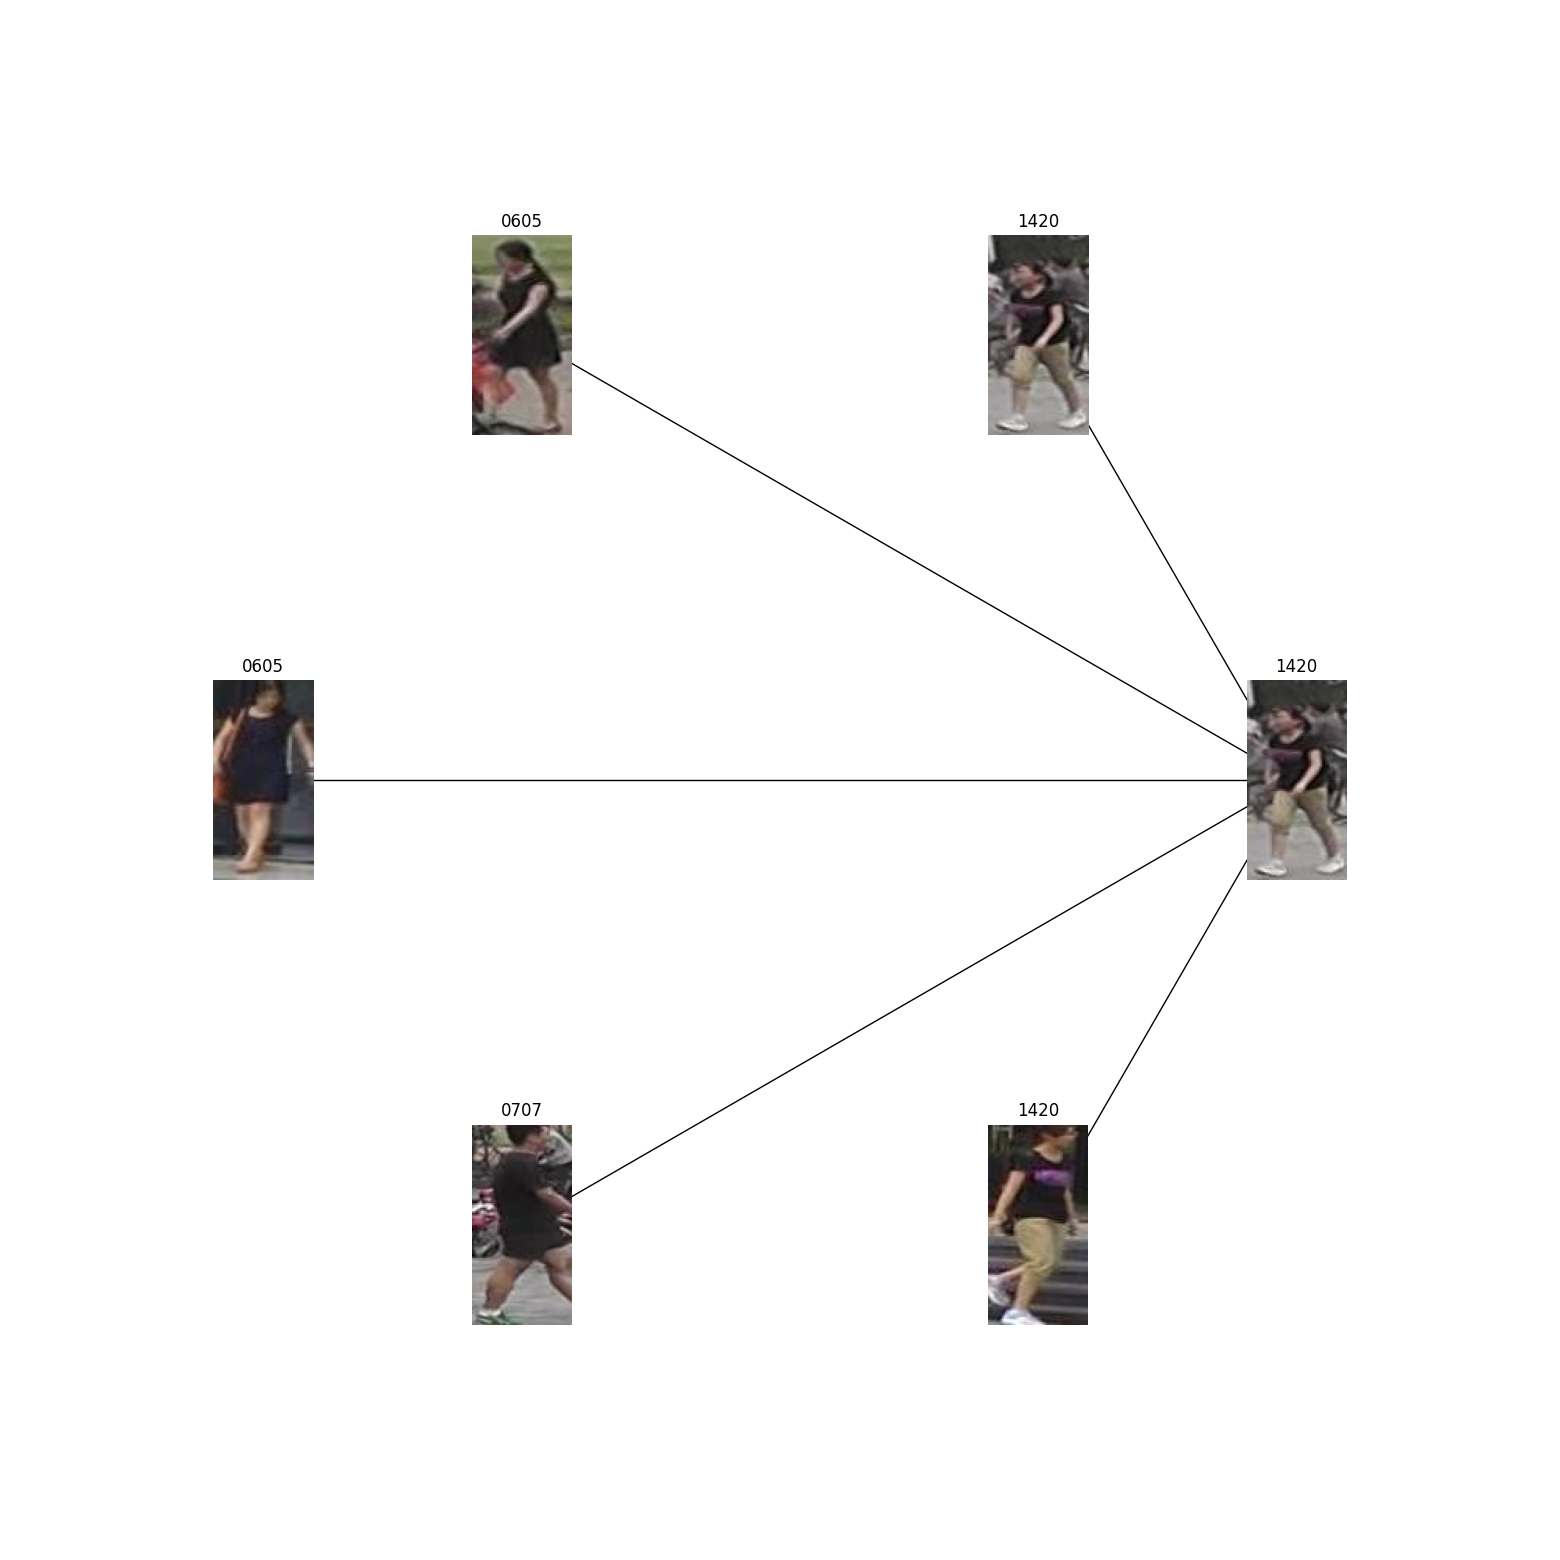

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);